In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler

In [2]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv") #, "Malfunction_dataset_SONATA")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv", "Vehicle_F-Model_2-Fabrication_attack-Sample_1")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
# df.to_csv("../../../Datasets/Survival/data/test_data.csv", index=False)

df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,name,class,dataset,type,Label
0,0.369422,0.078324,0.000444,0.009978,0.724212,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.453125,0.025104,0.000232,0.009977,0.045600,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,0.343750,0.000896,0.000248,0.009981,0.009991,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,0.328125,0.008395,0.000234,0.009978,0.047617,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,0.375000,0.038187,0.000241,0.009978,0.036785,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...
1735835,0.187500,0.000000,0.000248,0.020620,0.020620,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735836,0.265625,0.000000,0.000235,0.013305,0.013305,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735837,0.312500,0.000000,0.000242,0.013092,0.013092,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735838,0.265625,0.000000,0.000435,0.012329,0.012329,FreeDrivingData_20171231_Spark,Spark,Survival,none,0


In [3]:
# Stratify on the sub-dataset
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [4]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		128216		55098
Attack		128216		55098


In [5]:
# name_train = X_train["name"]
# name_test = X_test["name"]
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

In [6]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(random_state=0)
lm.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [7]:
f1_scores_train = cross_val_score(lm, X_train, y_train, scoring='f1', cv=10, n_jobs=-1)
print("Training F1: %0.4f (+/- %0.4f)" % (f1_scores_train.mean(), f1_scores_train.std()))

# f1_scores_test = f1_score(y_test, pred, average='weighted')
f1_scores_test = cross_val_score(lm, X_test, y_test, scoring='f1', cv=10, n_jobs=-1)
print("Testing F1:  %0.4f (+/- %0.4f)" % (f1_scores_test.mean(), f1_scores_test.std()))

pred = lm.predict(X_test)

kappa_scores = cohen_kappa_score(y_test, pred)
# kappa_scores = cross_val_score(clf, X_test, y_test, scoring='kappa', cv=10, n_jobs=-1)
print("Kappa score:  %0.4f" % (kappa_scores.mean()))

Training F1: 0.6950 (+/- 0.0031)
Testing F1:  0.7002 (+/- 0.0048)
Kappa score:  0.4399


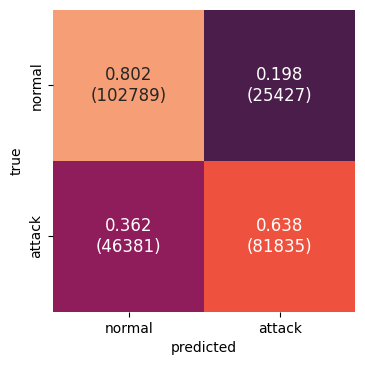

In [8]:
from plot_tools import plot_confusion_matrix

pred_train = lm.predict(X_train)

plot_confusion_matrix(y_train, pred_train, "RF, \"Survival\", all attacks, training data\n(# of instances)", cbar=False)

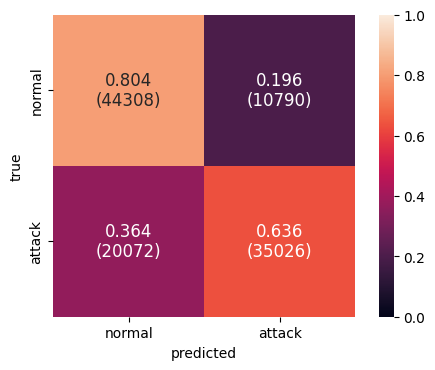

In [9]:
plot_confusion_matrix(y_test, pred, "RF, \"Survival\", all attacks, testing data\n(# of instances)")